In [1]:
# Commented out IPython magic to ensure Python compatibility.
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xvzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd /content  # Change this to the appropriate directory if needed
!pip install TA-Lib

--2023-11-17 19:00:53--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-11-17 19:00:56--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-11-17 19:00:57--  http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving nchc.dl.sourceforge.n

In [2]:
!pip install swig
!pip install wrds
!pip install pyportfolioopt

## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-thh1tk58
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-thh1tk58
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 17a1fc057dcb6dac9641abf0987e5890ab70700c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-o5cf5ney/elegantrl_1dfcaed82a374dc2b905862b517cd206
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-o5cf5ney/elegantrl_1dfcaed82a374dc2b905862b517cd206
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit dde7ee4daa226450a43280e4ee02f1f23b565aa2
  Preparing metadata (setup.py) ... done


In [3]:
import finrl
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import os
import talib

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [4]:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
get_ipython().run_line_magic('matplotlib', 'inline')
from finrl.config import INDICATORS

check_and_make_directories([TRAINED_MODEL_DIR])


import itertools

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [6]:
# Function to calculate KDJ
def calculate_kdj(df, n=9, m1=3, m2=3):
    low_list = df['low'].rolling(n).min()
    high_list = df['high'].rolling(n).max()
    rsv = (df['close'] - low_list) / (high_list - low_list) * 100
    k_values = rsv.ewm(span=m1, adjust=False).mean()
    d_values = k_values.ewm(span=m2, adjust=False).mean()
    j_values = 3 * k_values - 2 * d_values
    return k_values, d_values, j_values

In [7]:
TRAIN_START_DATE = '2013-01-01' #start date of training data
TRAIN_END_DATE = '2018-01-01'   #end date of training data
TRADE_START_DATE = '2018-01-01' #start date of trading data
TRADE_END_DATE = '2022-12-31'   #end date of trading data

In [8]:
# fetching data from the Yahoo finance by giving the start and end date and the top 30 tickers
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [9]:
df_raw.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day
0,2013-01-02,19.779285,19.821428,19.343929,16.769094,560518000,AAPL,2
1,2013-01-02,87.360001,89.239998,87.290001,66.515793,5772800,AMGN,2
2,2013-01-02,58.330002,58.950001,58.310001,50.327690,6091400,AXP,2
3,2013-01-02,76.550003,77.330002,76.449997,64.583855,5036400,BA,2
4,2013-01-02,92.949997,94.440002,92.949997,69.443268,11590000,CAT,2


In [10]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (2517, 8)
Successfully added vix
Successfully added turbulence index


In [11]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
# Calculate KDJ and add to the dataframe
n = 9  # Period for calculating KDJ
m1 = 3  # Smoothing period for %K
m2 = 3  # Smoothing period for %D

k_values, d_values, j_values = calculate_kdj(processed_full, n, m1, m2)
processed_full['k_values'] = k_values
processed_full['d_values'] = d_values
processed_full['j_values'] = j_values

processed_full = processed_full.fillna(0)
processed_full.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,k_values,d_values,j_values
0,2013-01-02,AAPL,19.779285,19.821428,19.343929,16.769094,560518000.0,2.0,0.0,16.962608,...,0.0,-66.666667,100.0,16.769094,16.769094,14.68,0.0,0.0,0.0,0.0
1,2013-01-02,AMGN,87.360001,89.239998,87.290001,66.515793,5772800.0,2.0,0.0,16.962608,...,0.0,-66.666667,100.0,66.515793,66.515793,14.68,0.0,0.0,0.0,0.0
2,2013-01-02,AXP,58.330002,58.950001,58.310001,50.327690,6091400.0,2.0,0.0,16.962608,...,0.0,-66.666667,100.0,50.327690,50.327690,14.68,0.0,0.0,0.0,0.0
3,2013-01-02,BA,76.550003,77.330002,76.449997,64.583855,5036400.0,2.0,0.0,16.962608,...,0.0,-66.666667,100.0,64.583855,64.583855,14.68,0.0,0.0,0.0,0.0
4,2013-01-02,CAT,92.949997,94.440002,92.949997,69.443268,11590000.0,2.0,0.0,16.962608,...,0.0,-66.666667,100.0,69.443268,69.443268,14.68,0.0,0.0,0.0,0.0


In [13]:
#Spliting the data for training and trading
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


36511
36482


In [14]:
#saving the split data into csv file
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
train = pd.read_csv('train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']

In [16]:
#Construct the environment
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,  # Maximum number of trading days in each episode
    "initial_amount": 1000000,  # Initial capital
    "num_stock_shares": num_stock_shares,  # List to track the number of shares held
    "buy_cost_pct": buy_cost_list,  # Buying cost percentages for each stock
    "sell_cost_pct": sell_cost_list,  # Selling cost percentages for each stock
    "state_space": state_space,  # Size and configuration of the state space
    "stock_dim": stock_dimension,  # Number of different stocks
    "tech_indicator_list": INDICATORS,  # List of technical indicators
    "action_space": stock_dimension,  # Size of the action space (number of stocks to buy/sell)
    "reward_scaling": 1e-4  # Scaling factor for rewards
}
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [18]:
#creating environment of training
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [19]:
#training DRL agents
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True
if_using_dqn = True

In [20]:
# ### Agent 1: A2C

agent = DRLAgent(env = env_train)
A2C_PARAMS = {
    "n_steps": 128,
    "ent_coef": 0.001,
    "learning_rate": 0.0001,
}

model_a2c = agent.get_model("a2c",model_kwargs = A2C_PARAMS)

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

{'n_steps': 128, 'ent_coef': 0.001, 'learning_rate': 0.0001}
Using cpu device
Logging to results/a2c
day: 1258, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1796206.84
total_reward: 796206.84
total_cost: 137926.01
total_trades: 34181
Sharpe: 1.010
---------------------------------------
| time/                 |             |
|    fps                | 138         |
|    iterations         | 100         |
|    time_elapsed       | 92          |
|    total_timesteps    | 12800       |
| train/                |             |
|    entropy_loss       | -41.1       |
|    explained_variance | -0.043      |
|    learning_rate      | 0.0001      |
|    n_updates          | 99          |
|    policy_loss        | 23.3        |
|    reward             | -0.50362784 |
|    std                | 1           |
|    value_loss         | 4.89        |
---------------------------------------
day: 1258, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1685012.52
total_reward: 685

In [21]:
# ### Agent 2: DDPG
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "batch_size": 64,
}
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

{'buffer_size': 100000, 'learning_rate': 0.0001, 'batch_size': 64}
Using cpu device
Logging to results/ddpg


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 47         |
|    time_elapsed    | 106        |
|    total_timesteps | 5036       |
| train/             |            |
|    actor_loss      | 68         |
|    critic_loss     | 2.88e+03   |
|    learning_rate   | 0.0001     |
|    n_updates       | 3777       |
|    reward          | -1.0367935 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 40         |
|    time_elapsed    | 248        |
|    total_timesteps | 10072      |
| train/             |            |
|    actor_loss      | 26.6       |
|    critic_loss     | 1.22e+03   |
|    learning_rate   | 0.0001     |
|    n_updates       | 8813       |
|    reward          | -1.0367935 |
-----------------------------------
day: 1258, episode: 50
begin_total_asset: 1000000.00
end_total_a

In [22]:
#### Agent 3: PPO
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 128,
    "ent_coef": 0.001,
    "learning_rate": 0.0001,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)


trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None


trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

{'n_steps': 128, 'ent_coef': 0.001, 'learning_rate': 0.0001}
Using cpu device
Logging to results/ppo


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 1275         |
|    total_timesteps      | 168320       |
| train/                  |              |
|    approx_kl            | 0.0009777602 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | -0.0982      |
|    learning_rate        | 0.0001       |
|    loss                 | 6.12         |
|    n_updates            | 13140        |
|    policy_gradient_loss | -0.00548     |
|    reward               | 0.65955025   |
|    std                  | 1            |
|    value_loss           | 21.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 131          |
|    iterations           | 1316         |
|    time_elapsed         | 1276         |
|    total_timesteps      | 168448       |
| t

In [27]:
# ### Agent 4: TD3
agent = DRLAgent(env = env_train)
TD3_PARAMS = {
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "batch_size": 64,
}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)



trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None



trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

{'buffer_size': 100000, 'learning_rate': 0.0001, 'batch_size': 64}
Using cpu device
Logging to results/td3
day: 1258, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 2298393.58
total_reward: 1298393.58
total_cost: 1975.59
total_trades: 14363
Sharpe: 1.456
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 46         |
|    time_elapsed    | 108        |
|    total_timesteps | 5036       |
| train/             |            |
|    actor_loss      | -9.02      |
|    critic_loss     | 884        |
|    learning_rate   | 0.0001     |
|    n_updates       | 3777       |
|    reward          | -0.9814365 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 39         |
|    time_elapsed    | 253        |
|    total_timesteps | 10072      |
| train/             |            |
|    actor_l

In [30]:
# ### Agent 5: SAC

agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "batch_size": 64,
    "learning_starts": 100,

}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

{'buffer_size': 100000, 'learning_rate': 0.0001, 'batch_size': 64, 'learning_starts': 100}
Using cpu device
Logging to results/sac
day: 1258, episode: 340
begin_total_asset: 1000000.00
end_total_asset: 2446482.18
total_reward: 1446482.18
total_cost: 33543.29
total_trades: 22140
Sharpe: 1.119
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 32         |
|    time_elapsed    | 155        |
|    total_timesteps | 5036       |
| train/             |            |
|    actor_loss      | 3.6e+03    |
|    critic_loss     | 1.44e+04   |
|    ent_coef        | 1.4        |
|    ent_coef_loss   | -6.86      |
|    learning_rate   | 0.0001     |
|    n_updates       | 4935       |
|    reward          | -0.9441391 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 31         |
|    time_elapsed    | 

In [31]:
#backtesting
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [32]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [33]:
trained_a2c = A2C.load("trained_models/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load("trained_models/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load("trained_models/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load("trained_models/agent_td3") if if_using_td3 else None
trained_sac = SAC.load("trained_models/agent_sac") if if_using_sac else None

In [34]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [35]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [36]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [37]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else (None, None)

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else (None, None)

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!
hit end!
hit end!
hit end!
hit end!


In [38]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

In [39]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [40]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[ 40.72287369, 147.57380676,  90.7988739 , ...,  39.6901741 ,
         58.3628006 ,  88.95239258],
       [ 40.71578217, 150.35856628,  91.35869598, ...,  38.87458801,
         58.79888535,  89.72831726],
       [ 40.90490341, 149.72489929,  92.87828827, ...,  39.00062561,
         55.7542038 ,  89.80953217],
       ...,
       [129.30723572, 254.56680298, 144.25645447, ...,  36.56439972,
         35.73909378, 142.17553711],
       [125.3394165 , 252.6627655 , 141.91116333, ...,  36.15450287,
         35.05808258, 139.68417358],
       [128.88957214, 254.34448242, 145.1729126 , ...,  36.5737114 ,
         34.95546722, 140.53439331]])

In [41]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [ 0.08   0.074  0.055  0.126  0.064  0.087  0.071  0.033  0.071  0.067
  0.101  0.083 -0.001  0.083  0.069  0.088  0.032  0.068  0.087  0.044
  0.11   0.084  0.039  0.063  0.125  0.097  0.037  0.071  0.044]
Variance-Covariance matrix of returns
 [[2.257 0.596 0.399 0.528 0.647 0.71  0.593 0.436 0.443 0.661 0.434 0.545
  0.44  0.657 0.296 0.584 0.244 0.336 0.44  0.325 0.73  0.454 0.29  0.35
  0.468 0.558 0.258 0.518 0.288]
 [0.596 2.411 0.702 0.672 0.612 0.985 0.584 0.547 0.673 0.87  0.652 0.731
  0.493 0.691 0.695 0.841 0.34  0.422 0.567 0.865 0.624 0.651 0.46  0.506
  0.808 0.812 0.415 0.849 0.407]
 [0.399 0.702 1.493 0.601 0.644 0.71  0.48  0.48  0.536 0.89  0.503 0.606
  0.452 0.572 0.398 0.839 0.291 0.286 0.474 0.477 0.539 0.563 0.295 0.42
  0.511 0.709 0.328 0.54  0.288]
 [0.528 0.672 0.601 1.732 0.732 0.706 0.537 0.572 0.619 0.829 0.496 0.743
  0.533 0.6   0.427 0.768 0.35  0.372 0.58  0.47  0.539 0.565 0.344 0.466
  0.542 0.64  0.388 0.57

In [42]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([     0.,      0.,      0., 250320.,      0.,      0.,      0.,
            0.,      0.,      0., 216500.,      0.,      0.,      0.,
            0.,      0.,      0.,  20510.,  74310.,      0., 121570.,
            0.,      0.,      0., 304020.,  12770.,      0.,      0.,
            0.])

In [43]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([   0.   ,    0.   ,    0.   ,  890.669,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   , 1312.401,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  136.343,
        396.309,    0.   , 1522.55 ,    0.   ,    0.   ,    0.   ,
       1500.939,  116.655,    0.   ,    0.   ,    0.   ])

In [44]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

In [45]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['dji']).fetch_data()
# df_dji

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (877, 8)


In [46]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')
# dji

In [47]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

<ipython-input-47-af864998cd35>:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'account_value_x'} in the result is deprecated and will raise a MergeError in a future version.
  if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)


In [48]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('djia')
result.columns = col_name
result

,A2C,DDPG,PPO,TD3,SAC,Mean Var,djia
date,,,,,,,
2018-01-02,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.001744e+06,1.000000e+06
2018-01-03,1.000067e+06,1.000008e+06,1.000534e+06,9.998225e+05,1.000245e+06,1.007484e+06,1.003976e+06
2018-01-04,1.000164e+06,1.002261e+06,1.001280e+06,1.001732e+06,1.001597e+06,1.011820e+06,1.010115e+06
2018-01-05,1.000446e+06,1.008982e+06,1.003861e+06,1.003409e+06,1.007027e+06,1.032801e+06,1.019010e+06
2018-01-08,1.000516e+06,1.009608e+06,1.003869e+06,1.002844e+06,1.007467e+06,1.027834e+06,1.018490e+06
...,...,...,...,...,...,...,...
2022-12-22,1.478158e+06,1.381410e+06,1.544894e+06,1.483012e+06,1.345558e+06,1.820366e+06,NaN
2022-12-23,1.486048e+06,1.386527e+06,1.551355e+06,1.491477e+06,1.351569e+06,1.831307e+06,NaN
2022-12-27,1.485666e+06,1.387331e+06,1.552265e+06,1.493529e+06,1.353234e+06,1.830987e+06,NaN


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

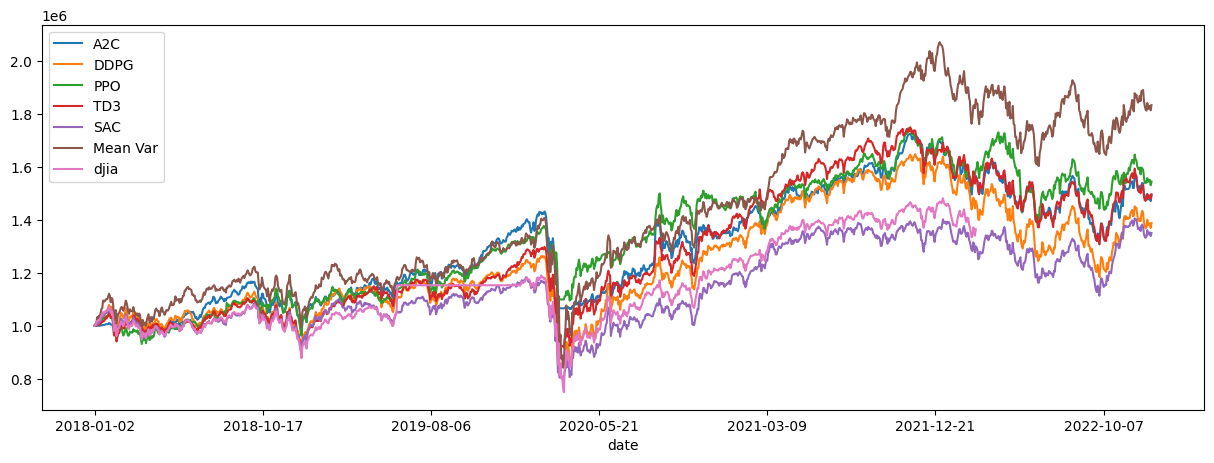

In [49]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()